# Integrating WOFOST Simulation with Bandits

In [1]:
import os.path
import math
from math import exp, log, sqrt
import csv
import warnings
from datetime import datetime
import random
import time
import numpy as np
import pandas as pd

from pcse.fileinput import CABOFileReader
from pcse.db import NASAPowerWeatherDataProvider
from pcse.base import ParameterProvider
from pcse.engine import Engine

from src.actions import AgroActions

Platform not recognized, using system temp directory for PCSE settings.
Platform not recognized, using system temp directory for PCSE settings.


## Create Experts

Let's create some experts, starting with some silly ones...

### Uniform Expert

An expert that recommends all actions with equal probability.

In [2]:
class UniformExpert:
    def __init__(self, actions):
        self.actions = actions
        self.n_actions = len(self.actions)

    def give_advice(self):
        return np.ones(self.n_actions) / self.n_actions

    def update(self, args):
        pass

### Stubborn Expert

An expert that randomly picks an action and sticks with it.

In [3]:
class Expert:
    def __init__(self, actions):
        self.actions = actions
        self.n_actions = len(self.actions)
        self.stubborn_action = np.random.default_rng().choice(self.n_actions, shuffle=False)

    def give_advice(self):
        advice = np.zeros(self.n_actions)
        advice[self.stubborn_action] = 1
        return advice

    def update(self, args):
        pass

### Idle Expert

An expert that recommends doing nothing.

In [4]:
class NoActionExpert(Expert):
    def __init__(self, actions):
        super().__init__(actions)
        self.stubborn_action = 0

### Randomized WOFOST Expert

An expert that recommends each action with probability that is proportional to the WOFOST yield.

In [5]:
class WofostExpert(Expert):
    def __init__(self, actions):
        super().__init__(actions)
        self.yields = np.zeros(self.n_actions)

    def update(self, yields):
        self.yields = yields

    def give_advice(self):
        advice = self.yields / np.sum(self.yields)
        return advice

### Perturbed Randomized WOFOST Expert

This expert is similar to the randomized WOFOST expert but the probability distribution is perturbed with Gaussian noise.

In [6]:
class PerturbedWofostExpert(WofostExpert):
    def __init__(self, actions, noise_scale=.1):
        super().__init__(actions)
        if not isinstance(noise_scale, float):
            raise TypeError('noise_scale must be float')
        if not noise_scale >= 0:
            raise ValueError('noise_scale must be nonnegative')
        self.noise_scale = noise_scale

    def give_advice(self):
        original_advice = self.yields / np.sum(self.yields)
        advice = np.zeros(self.n_actions)
        advice_sum = 0
        n_sampling = 0
        max_n_sampling = 5
        while advice_sum < 1e-3:
            n_sampling += 1
            advice = original_advice + np.random.default_rng().normal(0, self.noise_scale, self.n_actions)
            advice = np.clip(advice, 0, 1e3)
            advice_sum = np.sum(advice)
            if n_sampling > max_n_sampling:
                advice = np.ones(self.n_actions)
        advice = advice / np.sum(advice)
        return advice

### Complementary WOFOST Expert

An expert that copys the opposite of the WOFOST expert's recommendation.

In [7]:
class ComplementaryWofostExpert(WofostExpert):
    def __init__(self, actions):
        super().__init__(actions)

    def give_advice(self):
        advice = 1 - self.yields / np.sum(self.yields)
        advice = advice / np.sum(advice)
        return advice

### Minimum WOFOST Expert

An expert that recommends the action that gives the lowest yield. The worst expert ever...

In [8]:
class MinWofostExpert(WofostExpert):
    def __init__(self, actions):
        super().__init__(actions)

    def give_advice(self):
        idx = np.argmin(self.yields)
        advice = np.zeros(self.n_actions)
        advice[idx] = 1
        return advice

### Maximum WOFOST Expert

An expert that recommends the action that gives the highest yield. The best expert ever!

In [9]:
class MaxWofostExpert(WofostExpert):
    def __init__(self, actions):
        super().__init__(actions)

    def give_advice(self):
        idx = np.argmax(self.yields)
        advice = np.zeros(self.n_actions)
        advice[idx] = 1
        return advice

### Perturbed Maximum WOFOST Expert

This expert is similar to the maximum WOFOST expert but the probability distribution is perturbed with Gaussian noise.

In [10]:
class PerturbedMaxWofostExpert(WofostExpert):
    def __init__(self, actions, noise_scale=.1):
        super().__init__(actions)
        if not isinstance(noise_scale, float):
            raise TypeError('noise_scale must be float')
        if not noise_scale >= 0:
            raise ValueError('noise_scale must be nonnegative')
        self.noise_scale = noise_scale

    def give_advice(self):
        idx = np.argmax(self.yields)
        original_advice = np.zeros(self.n_actions)
        original_advice[idx] = 1
        advice = np.zeros(self.n_actions)
        advice_sum = 0
        n_sampling = 0
        max_n_sampling = 5
        while advice_sum < 1e-3:
            n_sampling += 1
            advice = original_advice + np.random.default_rng().normal(0, self.noise_scale, self.n_actions)
            advice = np.clip(advice, 0, 1e3)
            advice_sum = np.sum(advice)
            if n_sampling > max_n_sampling:
                advice = np.ones(self.n_actions)
        advice = advice / np.sum(advice)
        return advice

## Set up WOFOST Simulator

For the purpose of demonstration, we use data of the Netherlands. We use TWSO as yield.

In [11]:
class Wofost:
    @staticmethod
    def init_wofost():
        data_dir = os.path.join(os.getcwd(), '../simulation/default_data')
        crop_file_name = 'crop.cab'
        soil_file_name = 'soil.cab'
        site_file_name = 'site.cab'
        config_file_name = 'WLP_NPK.conf'

        soildata = CABOFileReader(os.path.join(data_dir, soil_file_name))
        sitedata = CABOFileReader(os.path.join(data_dir, site_file_name))
        cropdata = CABOFileReader(os.path.join(data_dir, crop_file_name))
        config = os.path.join(data_dir, config_file_name)

        params = ParameterProvider(cropdata, sitedata, soildata)
        latitude, longitude = 51.97, 5.67
        wdp = NASAPowerWeatherDataProvider(latitude, longitude)

        return params, wdp, config

    @staticmethod
    def run_wofost(agromanagement, params, wdp, config):
        wofost = Engine(params, wdp, agromanagement, config)  # WLP_NPK
        wofost.run_till_terminate()
        r = wofost.get_summary_output()
        return r[0]["TWSO"]  # Can be changed according to crop choice

## Set up the Environment

This is the environment that creates rewards and evaluates actions. The WOFOST simulator is integrated into here.

In [12]:
class Environment:
    """Generate rewards and record history."""

    def __init__(self, actions, experts, record_best_expert=False, **kwargs):
        self.actions = actions
        self.n_actions = len(self.actions)
        self.experts = experts
        # Wofost related
        params, wdp, config = Wofost.init_wofost()
        self.wofost_params = [params, wdp, config]
        self.yields = np.empty(self.n_actions)

        self.current_rewards = np.empty(self.n_actions)
        self.record_best_expert = record_best_expert
        if 'means' in kwargs:
            assert len(kwargs['means']) == self.n_actions, 'means and actions must be the same length'
            self.means = kwargs['means']
        if 'alphas' in kwargs:
            assert len(kwargs['alphas']) == self.n_actions, 'alphas and actions must be the same length'
            self.alphas = kwargs['alphas']
        if 'betas' in kwargs:
            assert len(kwargs['betas']) == self.n_actions, 'betas and actions must be the same length'
            self.betas = kwargs['betas']
        self.t = 1
        self.history = {}

    @staticmethod
    def sample_random_year():
        # Sample year from a non-stationary distribution
        random.seed(time.time())
        years_complete_weather = list(range(1984, 2000)) + [2002] + list(range(2004, 2016)) + [2017, 2019]
        year = random.choice(years_complete_weather)
        return year

    def update(self):
        year = self.sample_random_year()
        self.actions, _ = AgroActions().create_actions([0, 1, 4, 7], [0, 15], year=year)
        # Run Wofost to obtain yield for each action
        self.yields = np.zeros(self.n_actions)
        for i, action in enumerate(self.actions):
            self.yields[i] = Wofost.run_wofost(action, *self.wofost_params)

        for expert in self.experts:
            expert.update(self.yields)

    def reward_bernoulli(self, action_id):
        self.current_rewards = (np.random.uniform(size=self.n_actions) < self.means) * 1
        return self.current_rewards[action_id]

    def reward_beta(self, action_id):
        self.current_rewards = np.random.default_rng().beta(self.alphas, self.betas)
        return self.current_rewards[action_id]

    def reward_wofost(self, action_id):
        self.current_rewards = self.yields / np.max(self.yields)
        return self.current_rewards[action_id]

    def add_history(self, action_id, reward, expert_weights, advice):
        expert_weights = expert_weights / np.sum(expert_weights)
        expert_mean_rewards = np.matmul(advice, self.current_rewards)
        self.history[self.t] = {'action_id': action_id, 'reward': reward,
                                'expert_weights': expert_weights, 'expert_mean_rewards': expert_mean_rewards}
        if self.record_best_expert:
            max_val = np.max(expert_mean_rewards)
            best_expert_ids = []
            for expert_id, expert_mean_reward in enumerate(expert_mean_rewards):
                if abs(expert_mean_reward - max_val) < 1e-6:
                    best_expert_ids.append(expert_id)
            self.history[self.t].update({'best_expert_ids': best_expert_ids,
                                         'best_expert_mean_reward': max_val})
        self.t += 1

    def save_history_to_csv(self, file_dir='', filename='history', timestamp=False):
        if timestamp:
            filename += f'_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
        if '.csv' not in filename:
            filename += '.csv'
        with open(file_dir + filename, mode='w') as file:
            fieldnames = ['time', 'action_id', 'reward', 'expert_weights', 'expert_mean_rewards']
            if self.record_best_expert:
                fieldnames.extend(['best_expert_ids', 'best_expert_mean_reward'])
            writer = csv.writer(file, delimiter=',')
            writer.writerow(fieldnames)
            for t in range(1, len(self.history) + 1):
                record = self.history[t]
                if self.record_best_expert:
                    writer.writerow([t, record['action_id'], record['reward'],
                                     record['expert_weights'], record['expert_mean_rewards'],
                                     record['best_expert_ids'], record['best_expert_mean_reward']])
                else:
                    writer.writerow([t, record['action_id'], record['reward'],
                                     record['expert_weights'], record['expert_mean_rewards']])

    def save_actions_to_csv(self, file_dir='', filename='actions', timestamp=False):
        if timestamp:
            filename += f'_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
        if '.csv' not in filename:
            filename += '.csv'
        with open(file_dir + filename, mode='w') as file:
            fieldnames = ['action_id', 'event_signal', 'name', 'comment', 'events_table']
            writer = csv.DictWriter(file, fieldnames=fieldnames)
            writer.writeheader()
            for action_id, action in enumerate(self.actions):
                action_dict = {'action_id': action_id}
                campaign_start_date = list(action[0].keys())[0]
                action_description = action[0][campaign_start_date]['TimedEvents']
                if len(action_description) > 0:
                    for event_id in range(len(action_description)):
                        events_table = action_description[event_id]['events_table']
                        for entry_id in range(len(events_table)):
                            entry = events_table[entry_id]
                            date = list(entry.keys())[0]
                            events_table[entry_id] = {f'{date.month}/{date.day}': entry[date]}
                        action_dict.update(action_description[event_id])
                        writer.writerow(action_dict)
                else:
                    writer.writerow(action_dict)

## Define the Exp4.R Algorithm

This is the bandit algorithm where learning takes place.

In [13]:
class Exp4R:
    def __init__(self, actions, experts, T, delta=.1, rho=None):
        if not isinstance(actions, (list, tuple)):
            raise TypeError('actions must be either list or tuple')
        if not len(actions) > 0:
            raise ValueError('actions cannot be empty')
        self.actions = actions
        self.n_actions = len(self.actions)

        if not isinstance(experts, (list, tuple)):
            raise TypeError('experts must be either list or tuple')
        if not len(experts) > 0:
            raise ValueError('experts cannot be empty')
        self.experts = experts
        self.n_experts = len(experts)

        if not isinstance(T, int):
            raise TypeError('T must be int')
        if not T > 0:
            raise ValueError('T must be positive')
        self.T = T

        if not isinstance(delta, float):
            raise TypeError('delta must be float')
        if not 0 < delta <= 1:
            raise ValueError('delta must be positive and no larger than 1')
        self.delta = delta

        self.beta = sqrt(log(2 * self.n_experts / self.delta) / self.n_actions / self.T)
        assert self.beta ** 2 <= math.e - 2, 'ln(2N/delta) <= (e-2)KT must hold'

        if rho is None:
            rho = sqrt(log(self.n_experts) / self.n_actions / self.T)
        elif not isinstance(rho, float):
            raise TypeError('rho must be float')
        if not 0 < rho <= 1 / self.n_actions:
            raise ValueError(f'rho must be positive and no larger than {1 / self.n_actions}')
        else:
            self.rho = rho

        if not 49 * self.n_actions * log(2 * self.n_experts / self.delta) < self.T:
            warnings.warn('The regret upper bound is vacuous for the inputs given.\n'
                          'Try one or multiple of the following options:\n'
                          '- increasing time horizon\n'
                          '- increasing delta\n'
                          '- reducing the number of actions\n'
                          '- reducing the number of experts')

        self.t = 1

        self.expert_weights = np.ones(self.n_experts)
        self.expert_thresholds = np.zeros(self.n_experts)

        self.advice = np.empty((self.n_experts, self.n_actions))
        self.action_pmf = np.empty(self.n_actions)

    def get_advice(self):
        for expert_id in range(self.n_experts):
            self.advice[expert_id] = self.experts[expert_id].give_advice()
            assert abs(1 - np.sum(self.advice[expert_id])) <= 1e-2, \
                f'incorrect advice distribution, expert_id: {expert_id}\nadvice:{self.advice[expert_id]}'

    def combine_advice(self):
        self.action_pmf = ((1 - self.n_actions * self.rho) * np.matmul(self.expert_weights, self.advice)
                           / np.sum(self.expert_weights) + self.rho)

    def sample_action_id(self):
        return np.random.default_rng().choice(self.n_actions, p=self.action_pmf, shuffle=False)

    def update_weights(self, action_id, reward):
        mean_coeff = reward / self.action_pmf[action_id]
        for expert_id in range(self.n_experts):
            uncertainty = np.sum(np.divide(self.advice[expert_id], self.action_pmf))
            self.expert_weights[expert_id] *= exp(self.rho / 2 * (mean_coeff * self.advice[expert_id][action_id]
                                                                  + self.beta * uncertainty))
            self.expert_thresholds[expert_id] += uncertainty
        self.t += 1

    def get_expert_thresholds(self):
        self.expert_thresholds = ((1 + self.expert_thresholds / self.n_actions / self.T)
                                  * log(2 * self.n_experts / self.delta))

    def threshold_test(self):
        self.get_expert_thresholds()
        expert_weight_ranking = np.flip(self.expert_weights.argsort())
        pairwise_ranking = []
        for i in range(self.n_experts-1):
            better_id = expert_weight_ranking[i]
            j = self.n_experts - 1
            while j > i:
                worse_id = expert_weight_ranking[j]
                diff = log(self.expert_weights[better_id]) - log(self.expert_weights[worse_id])
                if diff > self.expert_thresholds[better_id]:
                    pairwise_ranking.append((better_id, worse_id))
                j -= 1
        if len(pairwise_ranking) > 0:
            message = 'Estimated pairwise expert ranking as follows:'
            for better_id, worse_id in pairwise_ranking:
                message += f'\nExpert {better_id} better than Expert {worse_id}'
        else:
            message = 'Cannot decide on pairwise expert ranking...'
        print(message)

    def print_regret_upper_bound(self):
        regret_upper_bound = 7 * sqrt(self.n_actions * self.T * log(2 * self.n_experts / self.delta))
        print(f'Regret upper bound: {regret_upper_bound}')

## Simulation

In [14]:
import sys

sys.path.append('..')

from tqdm import tqdm

### Inputs

We need to decide on the time horizon, actions, and experts.

In [15]:
RECORD_BEST_EXPERT = True
TIME_HORIZON = 100
DELTA = .1
ACTIONS, _ = AgroActions().create_actions([0, 1, 4, 7], [0, 15], year=2019)
EXPERTS = ([UniformExpert(ACTIONS)]
           + [Expert(ACTIONS) for _ in range(3)]
           + [NoActionExpert(ACTIONS)]
           + [WofostExpert(ACTIONS)]
           + [PerturbedWofostExpert(ACTIONS, 1e-2)]
           + [PerturbedWofostExpert(ACTIONS, 1.0)]
           + [ComplementaryWofostExpert(ACTIONS)]
           + [MinWofostExpert(ACTIONS)]
           + [MaxWofostExpert(ACTIONS)]
           + [PerturbedMaxWofostExpert(ACTIONS, 1e-2)]
           + [PerturbedMaxWofostExpert(ACTIONS, 1.0)])

### Initialization

Let's initialize the environment.

In [16]:
env = Environment(ACTIONS, EXPERTS, RECORD_BEST_EXPERT)

We can save the action details to a CSV file.

In [17]:
env.save_actions_to_csv()

In [18]:
df_actions = pd.read_csv('actions.csv')
print(df_actions.head())

   action_id event_signal                           name  \
0          0          NaN                            NaN   
1          1    apply_npk  Timed N/P/K application table   
2          2     irrigate   Irrigation application table   
3          3     irrigate   Irrigation application table   
4          3    apply_npk  Timed N/P/K application table   

                           comment  \
0                              NaN   
1  All fertilizer amounts in kg/ha   
2     All irrigation amounts in cm   
3     All irrigation amounts in cm   
4  All fertilizer amounts in kg/ha   

                                        events_table  
0                                                NaN  
1  [{'1/1': {'N_amount': 15, 'P_amount': 15, 'K_a...  
2  [{'1/1': {'amount': 10, 'efficiency': 0.7}}, {...  
3  [{'1/1': {'amount': 10, 'efficiency': 0.7}}, {...  
4  [{'1/1': {'N_amount': 15, 'P_amount': 15, 'K_a...  


In [19]:
print(df_actions.loc[0])

action_id         0
event_signal    NaN
name            NaN
comment         NaN
events_table    NaN
Name: 0, dtype: object


In [20]:
print(df_actions.loc[1])

action_id                                                       1
event_signal                                            apply_npk
name                                Timed N/P/K application table
comment                           All fertilizer amounts in kg/ha
events_table    [{'1/1': {'N_amount': 15, 'P_amount': 15, 'K_a...
Name: 1, dtype: object


In [21]:
print(df_actions.loc[2])

action_id                                                       2
event_signal                                             irrigate
name                                 Irrigation application table
comment                              All irrigation amounts in cm
events_table    [{'1/1': {'amount': 10, 'efficiency': 0.7}}, {...
Name: 2, dtype: object


Let's also initialize the Exp4.R algorithm.

In [22]:
exp4r = Exp4R(ACTIONS, EXPERTS, TIME_HORIZON, delta=DELTA)

/Users/xfmeng/.virtualenvs/bandits/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: The regret upper bound is vacuous for the inputs given.
Try one or multiple of the following options:
- increasing time horizon
- increasing delta
- reducing the number of actions
- reducing the number of experts


Before the game starts, we can provide a high-probability upper bound on the regret of Exp4.R.

In [23]:
exp4r.print_regret_upper_bound()

Regret upper bound: 466.8819121960163


### The Game

At time $t = 1,2, \dots , T$,
1. The environment sets a reward vector $r(t) \in [0, 1]^K$ where $r_a(t)$ is the reward of action $a$.
1. Each expert $i$ provides their advice $\xi_i(t)$, which is a probability vector over actions.
1. After observing all experts’ advice but not the rewards, Exp4.R combines the advice and samples an action $a(t)$.
1. Exp4.R receives the reward $r_{a(t)}(t)$ from the environment and no other information.

In [24]:
for _ in tqdm(range(TIME_HORIZON)):
    env.update()
    exp4r.get_advice()
    exp4r.combine_advice()
    action_id = exp4r.sample_action_id()
    reward = env.reward_wofost(action_id)
    env.add_history(action_id, reward, exp4r.expert_weights, exp4r.advice)
    exp4r.update_weights(action_id, reward)

100%|██████████| 100/100 [07:10<00:00,  4.31s/it]


We can save the history of the game to a CSV file.

In [25]:
env.save_history_to_csv()

In [26]:
df_history = pd.read_csv('history.csv')
print(df_history.head())

   time  action_id   reward  \
0     1          0  0.15859   
1     2          1  1.00000   
2     3          1  1.00000   
3     4          1  1.00000   
4     5          5  1.00000   

                                      expert_weights  \
0  [0.07692308 0.07692308 0.07692308 0.07692308 0...   
1  [0.07735095 0.0760629  0.0760629  0.0760629  0...   
2  [0.07644999 0.07288781 0.07288781 0.07288781 0...   
3  [0.07553573 0.06989094 0.06989094 0.06989094 0...   
4  [0.07435628 0.066923   0.066923   0.066923   0...   

                                 expert_mean_rewards best_expert_ids  \
0  [0.57929497 1.         1.         1.         0...   [1, 2, 3, 10]   
1  [0.56576561 1.         1.         1.         0...   [1, 2, 3, 10]   
2  [0.57435051 1.         1.         1.         0...   [1, 2, 3, 10]   
3  [0.56247253 1.         1.         1.         0...   [1, 2, 3, 10]   
4  [0.56610435 1.         1.         1.         0...   [1, 2, 3, 10]   

   best_expert_mean_reward  
0             

Which experts gave good advice? Depending on the setting and stochasticity, we may or may not be able to answer this question...

In [27]:
exp4r.threshold_test()

Cannot decide on pairwise expert ranking...


## Visualization

In [28]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import seaborn as sns

In [29]:
class ReadCSV:
    """Read simulation data into df."""

    def __init__(self, csv_path):
        df = pd.read_csv(csv_path)
        assert df.notnull().values.all(), 'Missing values'
        for col in {'expert_weights', 'expert_mean_rewards'}:
            df[col] = df[col].str.strip('[]').apply(lambda x: np.array(x.split()).astype(float))
        self.df = df

    def add_regret(self):
        assert 'best_expert_mean_reward' in self.df.columns, 'best_expert_mean_reward unrecorded'
        if 'regret' not in self.df.columns:
            self.df['regret'] = self.df['best_expert_mean_reward'] - self.df['reward']

Let's first check if we were correct about the regret bound...

In [30]:
def plot_time_series(csv_path, y, ylabel=None, cumsum=True,
                     style='whitegrid', save=False, filename_tag='', timestamp=False, plot_path=''):
    """Plot time series"""

    data = ReadCSV(csv_path)
    if y == 'regret':
        data.add_regret()
    data.df.set_index('time', inplace=True)
    s = data.df[y]
    if cumsum:
        s = s.cumsum()
    sns.set_theme(style=style)
    sns.set(rc={'figure.figsize':(10, 8)})
    lineplot = sns.lineplot(data=s, palette="tab10", linewidth=3)
    lineplot.set_xlabel('Time', fontsize=20)
    if ylabel is None:
        ylabel = f'Cumulative {y}'
    lineplot.set_ylabel(ylabel, fontsize=20)
    lineplot.tick_params(labelsize=15)
    if save:
        if filename_tag == '':
            filename_tag = y
        if timestamp:
            filename = f'time_series_{filename_tag}_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pdf'
        else:
            filename = f'time_series_{filename_tag}.pdf'
        plt.savefig(plot_path + filename, transparent=True)
    plt.show()
    plt.pause(3)
    plt.close()

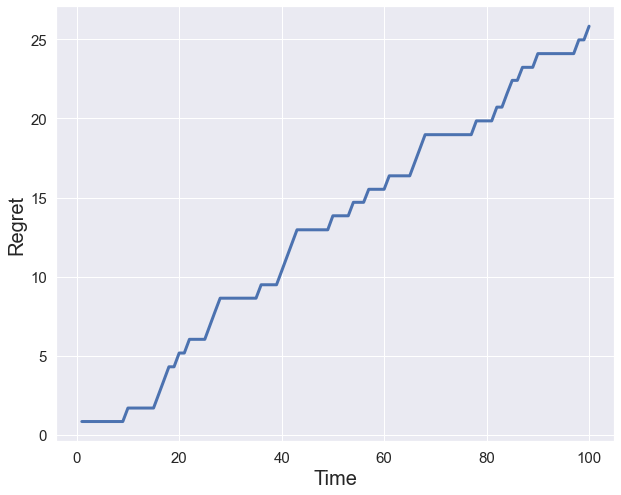

In [31]:
csv_path = 'history.csv'
plot_time_series(csv_path, 'regret', 'Regret', cumsum=True, save=True)

How did the weights on the experts evolve over time?

In [32]:
def animation_bar_chart(csv_path, xticklabels=None, ylim=None, sort_by_reward=True,
                        style='whitegrid', save=False, filename_tag='expert_weight', timestamp=False, plot_path=''):
    """Animate bar chart"""

    data = ReadCSV(csv_path)
    data.df.set_index('time', inplace=True)
    expert_weights = data.df['expert_weights']
    n_experts = len(expert_weights.loc[1])
    sns.set_theme(style=style)
    if xticklabels is None:
        xticklabels = np.arange(n_experts)
        rotate_xticklabels = True
    else:
        rotate_xticklabels = False
    x = np.arange(n_experts)
    if ylim is None:
        expert_final_weights = expert_weights.loc[len(expert_weights)]
        ylim = (0, min(1, 1.1*np.max(expert_final_weights)))
    if sort_by_reward:
        expert_mean_rewards = np.array(data.df['expert_mean_rewards'].values.tolist())
        expert_mean_rewards_over_time = np.sum(expert_mean_rewards, axis=0) / len(expert_mean_rewards)
        sorted_ids = expert_mean_rewards_over_time.argsort()
        for t in range(1, len(expert_weights)+1):
            expert_weights.at[t] = expert_weights.at[t][sorted_ids]
        xticklabels = np.array(xticklabels)[sorted_ids]
    width = .6
    fig, ax = plt.subplots()

    def init():
        ax.clear()
        ax.set_xlim(-.5, n_experts-.5)
        ax.set_ylim(*ylim)

    def animate(frame_id):
        init()
        time = frame_id + 1
        ax.bar(x, expert_weights.loc[time], width)
        ax.set_xlabel('Expert')
        ax.set_xticks(x)
        ax.set_ylabel('Weight')
        ax.set_title(f'Time {time}')
        if rotate_xticklabels:
            ax.set_xticklabels(xticklabels)
        else:
            ax.set_xticklabels(xticklabels, rotation=45, ha='right')
        fig.tight_layout()

    anim = FuncAnimation(fig, animate, init_func=init, frames=len(expert_weights), interval=200, repeat=False)

    if save:
        if timestamp:
            filename = f'animated_bar_chart_{filename_tag}_{datetime.now().strftime("%Y%m%d_%H%M%S")}.mp4'
        else:
            filename = f'animated_bar_chart_{filename_tag}.mp4'
        FFwriter = FFMpegWriter(fps=10)
        anim.save(plot_path + filename, writer=FFwriter)
    plt.show()
    plt.pause(3)
    plt.close()

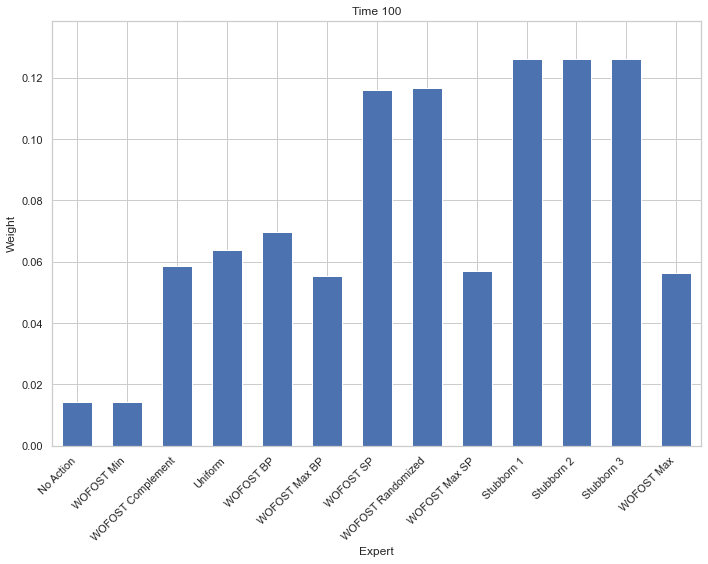

In [33]:
xticklabels = ['Uniform', 'Stubborn 1', 'Stubborn 2', 'Stubborn 3',
               'No Action', 'WOFOST Randomized', 'WOFOST SP', 'WOFOST BP',
               'WOFOST Complement', 'WOFOST Min', 'WOFOST Max', 'WOFOST Max SP', 'WOFOST Max BP']
animation_bar_chart(csv_path, xticklabels=xticklabels, save=True)

Let's now focus on the final weights...

In [34]:
def plot_bar_chart(csv_path, xticklabels=None, sort_by_reward=True,
                   style='whitegrid', save=False, filename_tag='expert_weight_reward', timestamp=False, plot_path=''):
    """Plot bar chart"""

    data = ReadCSV(csv_path)
    expert_final_weights = data.df.loc[data.df.index[-1], 'expert_weights']
    expert_mean_rewards = np.array(data.df['expert_mean_rewards'].values.tolist())
    expert_mean_rewards_over_time = np.sum(expert_mean_rewards, axis=0) / len(expert_mean_rewards)
    sns.set_theme(style=style)
    if xticklabels is None:
        xticklabels = np.arange(len(expert_final_weights))
        rotate_xticklabels = True
    else:
        rotate_xticklabels = False
    x = np.arange(len(expert_final_weights))
    if sort_by_reward:
        sorted_ids = expert_mean_rewards_over_time.argsort()
        expert_final_weights = expert_final_weights[sorted_ids]
        expert_mean_rewards_over_time = expert_mean_rewards_over_time[sorted_ids]
        xticklabels = np.array(xticklabels)[sorted_ids]
    width = .35
    fig, ax = plt.subplots()
    ax.bar(x - width / 2, expert_final_weights, width, label='Final weight')
    ax.bar(x + width / 2, expert_mean_rewards_over_time, width, label='Mean reward per time step')
    ax.set_xlabel('Expert', fontsize=20)
    ax.set_xticks(x)
    if rotate_xticklabels:
        ax.set_xticklabels(xticklabels, fontsize=18)
    else:
        ax.set_xticklabels(xticklabels, rotation=45, ha='right')
    ax.legend(fontsize=20)
    fig.tight_layout()
    if save:
        if timestamp:
            filename = f'bar_chart_{filename_tag}_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pdf'
        else:
            filename = f'bar_chart_{filename_tag}.pdf'
        plt.savefig(plot_path + filename, transparent=True)
    plt.show()
    plt.pause(3)
    plt.close()

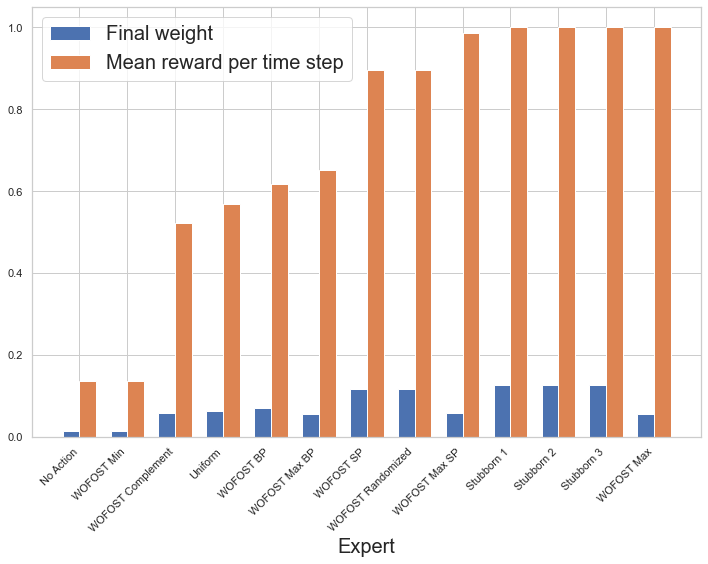

In [35]:
plot_bar_chart(csv_path, xticklabels=xticklabels, save=True)

## Synthetic Environment

Instead of using the WOFOST simulator, we create Bernoulli rewards.

### Inputs

In [ ]:
RECORD_OPTIMAL = True
TIME_HORIZON = int(1e4)
ACTIONS = [*range(5)]
EXPERTS = [UniformExpert(ACTIONS)] + [Expert(ACTIONS) for _ in range(9)]
MEAN_REWARDS = np.linspace(.1, .9, len(ACTIONS))

In [ ]:
### Initialization

In [ ]:
env = Environment(ACTIONS, EXPERTS, RECORD_OPTIMAL, means=MEAN_REWARDS)
exp4r = Exp4R(ACTIONS, EXPERTS, TIME_HORIZON)

### The Game

In [ ]:
for _ in tqdm(range(TIME_HORIZON)):
    exp4r.get_advice()
    exp4r.combine_advice()
    action_id = exp4r.sample_action_id()
    reward = env.reward_bernoulli(action_id)
    env.add_history(action_id, reward, exp4r.expert_weights, exp4r.advice)
    exp4r.update_weights(action_id, reward)

In [ ]:
env.save_history_to_csv(filename='history_synthetic')

In [ ]:
print('Simulation done!')

In [ ]:
exp4r.print_regret_upper_bound()

In [ ]:
exp4r.threshold_test()

In [ ]:
csv_path = 'history_synthetic.csv'
plot_time_series(csv_path, 'regret', 'Regret', cumsum=True, save=True, filename_tag='regret_synthetic')

In [ ]:
xticklabels = ['Uniform'] + [f'Stubborn {i}' for i in range(9)]
plot_bar_chart(csv_path, xticklabels=xticklabels, save=True, filename_tag='expert_weight_reward_synthetic')

In [ ]:
animation_bar_chart(csv_path, xticklabels=xticklabels, save=True, filename_tag='expert_weight_synthetic')

Instead of using the WOFOST simulator, we create Bernoulli rewards.

### Inputs

In [36]:
RECORD_OPTIMAL = True
TIME_HORIZON = int(1e4)
ACTIONS = [*range(5)]
EXPERTS = [UniformExpert(ACTIONS)] + [Expert(ACTIONS) for _ in range(9)]
MEAN_REWARDS = np.linspace(.1, .9, len(ACTIONS))

In [37]:
### Initialization

In [38]:
env = Environment(ACTIONS, EXPERTS, RECORD_OPTIMAL, means=MEAN_REWARDS)
exp4r = Exp4R(ACTIONS, EXPERTS, TIME_HORIZON)

### The Game

In [39]:
for _ in tqdm(range(TIME_HORIZON)):
    exp4r.get_advice()
    exp4r.combine_advice()
    action_id = exp4r.sample_action_id()
    reward = env.reward_bernoulli(action_id)
    env.add_history(action_id, reward, exp4r.expert_weights, exp4r.advice)
    exp4r.update_weights(action_id, reward)

100%|██████████| 10000/10000 [00:04<00:00, 2446.49it/s]


In [ ]:
env.save_history_to_csv(filename='history_synthetic')

In [40]:
print('Simulation done!')

Simulation done!


In [41]:
exp4r.print_regret_upper_bound()

Regret upper bound: 3602.898492608789


In [42]:
exp4r.threshold_test()

Estimated pairwise expert ranking as follows:
Expert 7 better than Expert 2
Expert 6 better than Expert 2
Expert 4 better than Expert 2
Expert 3 better than Expert 2
Expert 1 better than Expert 2


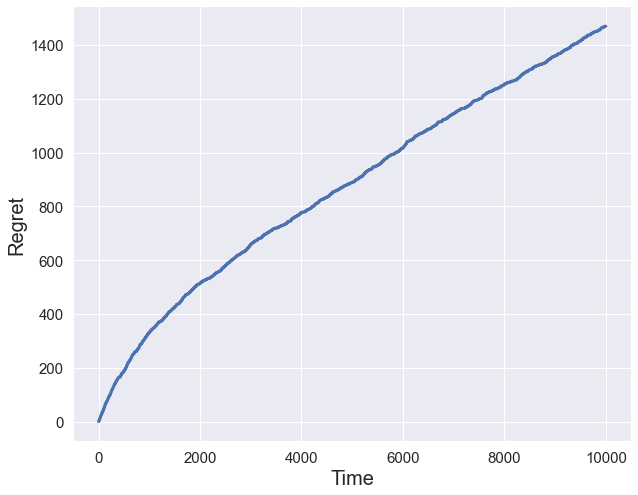

In [43]:
csv_path = 'history_synthetic.csv'
plot_time_series(csv_path, 'regret', 'Regret', cumsum=True, save=True, filename_tag='regret_synthetic')

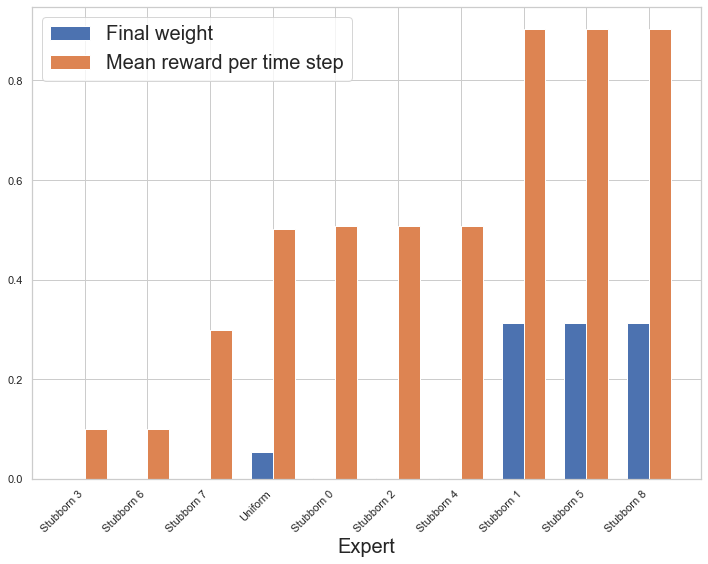

In [44]:
xticklabels = ['Uniform'] + [f'Stubborn {i}' for i in range(9)]
plot_bar_chart(csv_path, xticklabels=xticklabels, save=True, filename_tag='expert_weight_reward_synthetic')

In [ ]:
animation_bar_chart(csv_path, xticklabels=xticklabels, save=True, filename_tag='expert_weight_synthetic')